# First Half - Manual Backpropagation - Example 1:


Follow-along code with the original from Andrej Kaparthy: 

https://github.com/Tina-Gh/nn-zero-to-hero/tree/73c3fcc741f0ec104ca850b1fb0df90e7e8d4cde/lectures/micrograd

and the more production-ready version:

https://github.com/karpathy/micrograd

In [296]:
import math
import random
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [297]:
def f(x): 
    return 3*x**2 - 4*x + 5

In [298]:
f(3.0)

20.0

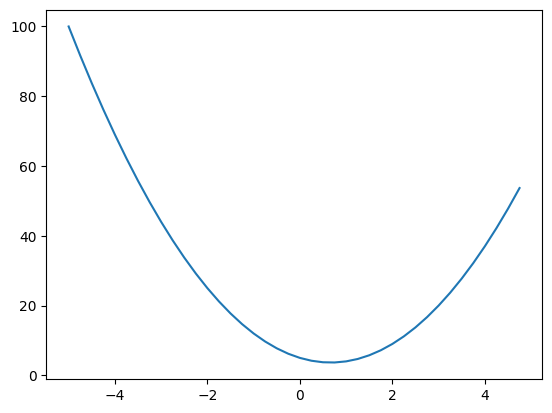

In [299]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [300]:
# link: https://www.geeksforgeeks.org/dunder-magic-methods-python/

class Value: 
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self._prev = set(_children)
        self._op = _op 
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self): 
        return f"Value(data={self.data})"

        
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other) # we are making sure other is of type Value, even if mistakenly assigned int.
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward # NOT with ()! because we don't want to call this function, we are storing it.
        return out 

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out 

        
    def __radd__(self, other): # other  + self
        return self + other

    def __rmul__(self, other): # other * self : so that if a*2 works (a bing a Value instance), then 2*a works too :D
        return self * other 


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward(): 
            self.grad += other * (self.data ** (other -1)) * out.grad 
        out._backward = _backward
        return out


    def __truediv__(self, other):
        out = self * (other**(-1))
        return out 

    
    def __neg__(self):
        out = self * (-1) 
        return out 


    def __sub__(self, other):
        out = self + (-other)
        return out


    def tanh(self):
        x = self.data 
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), label="tanh")

        def _backward(): 
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
        
        
    def exp(self): 
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        
        def _backward(): 
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

        
    def backward(self): 
        topo = [] 
        visited = set() 
        def build_topo(v): 
            if v not in visited: 
                visited.add(v) 
                for child in v._prev: 
                    build_topo(child) 
                topo.append(v) 
        build_topo(self) 

        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()




In [301]:
# for the sake of visualizaton: 

from graphviz import Digraph

def trace(root): 
    " build a set of all nodes and edges in a graph"

    nodes, edges = set(), set() 
    def build(v):
        if v not in nodes: 
            nodes.add(v) 
            for child in v._prev: 
                edges.add((child, v)) 
                build(child) 
    build(root) 
    return nodes, edges 

def draw_dot(root): 
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right 

    nodes, edges = trace(root) 
    for n in nodes: 
        uid = str(id(n))
        # create a rectangular ('record') node for any value in the graph 
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op: 
            # if this value is a result of a some operation, create an op node for it.
            dot.node(name=uid + n._op, label=n._op) 
            # and connect this node to it 
            dot.edge(uid+n._op , uid) 
            
    for n1, n2 in edges: 
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2))+n2._op) 

    return dot 

In [302]:
a = Value(2.0, label='a') # the same as a.__repr__()
b = Value(-3.0, label='b') 
# print(a + b) # the same as print(a.__add__(b))
# print(a*b) # the same as print(a.__mul__(b))    
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label='d'
# print(d._prev)
# print(d._op)
f = Value(-2.0, label='f') 
L = d*f; L.label='L'

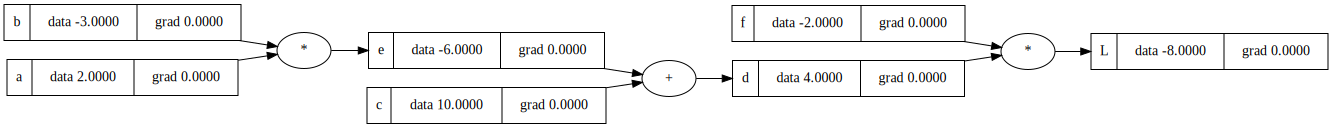

In [303]:
draw_dot(L)

In [304]:
# remember, we are doing the backpropagation manually!

In [305]:
def lol(): 

    
    a = Value(2.0, label='a') # the same as a.__repr__()
    b = Value(-3.0, label='b') 
    # print(a + b) # the same as print(a.__add__(b))
    # print(a*b) # the same as print(a.__mul__(b))    
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    # print(d._prev)
    # print(d._op)
    f = Value(-2.0, label='f') 
    L = d*f; L.label='L'
    L1 = L.data

    h = 0.001
    a = Value(2.0, label='a') # the same as a.__repr__()
    # a.data += h # gradient (of L) with respect to a
    b = Value(-3.0, label='b') 
    b.data += h # gradient with respec to b
    # print(a + b) # the same as print(a.__add__(b))
    # print(a*b) # the same as print(a.__mul__(b))    
    c = Value(10.0, label='c') # 10.0+h: gradient with respect to c
    e = a*b; e.label = 'e'
    # e.data += h # gradient with respect to e
    d = e + c; d.label='d'
    # d.data += h # gradient with respect to d
    # print(d._prev)
    # print(d._op)
    f = Value(-2.0, label='f') # -2.0+h: gradient with respect to f
    L = d*f; L.label='L'
    L2 = L.data # +h: gradient with respect to L

    print((L2 - L1)/h)

lol()

-3.9999999999995595


In [306]:
L.grad = 1.0
d.grad = -2.0 
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0 # b*f = (-3)*(-2) = 6
b.grad = -4.0 # a*f = (2)*(-2) = -4 

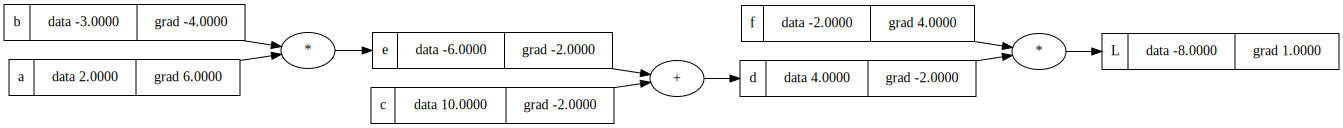

In [307]:
draw_dot(L)

In [308]:
print(L.data)

a.data += 0.01 * a.grad # increase in the direction of the gradient 
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b 
d = e + c 
L = d*f

# so, by nodging in the direction of the gradient, we expect a positive influence on L:
print(L.data)

# This is basically, one step of the optimization!

-8.0
-7.286496


# Manual Backpropagation - Example 2:

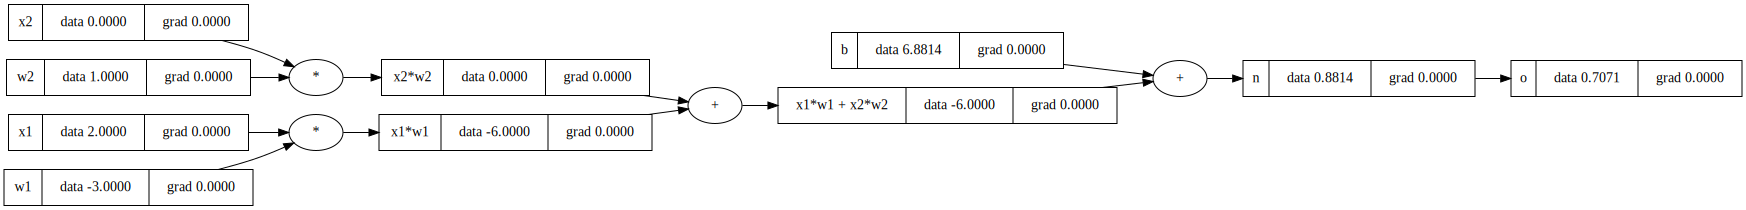

In [309]:
# inputs x1, x2 
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias 
b = Value(6.8813735870195432, label="b") # we change b from teh arbitrary 6.7 to 6.8813735870195432 for a reason later explained!
# x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n" 

# output - activation function 
o = n.tanh(); o.label="o"
draw_dot(o)

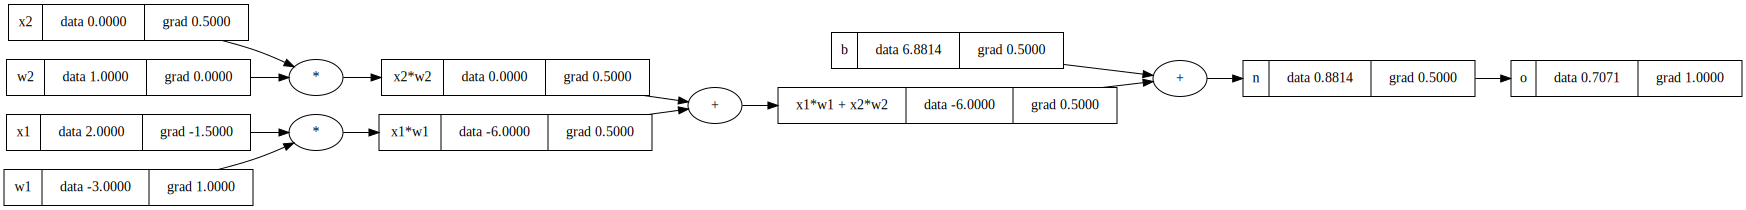

In [310]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5 # because grad travels through the "+" node (aka the same old chain rule)
b.grad = 0.5 # same as above explanation
x1w1.grad = 0.5 
x2w2.grad = 0.5 
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


draw_dot(o)

# Now, let's do backpropagation
# o = tanh(n) 
# do/dn = 1 - o**2 = 0.49
# therefore, we set n.grad = 0.5

draw_dot(o)

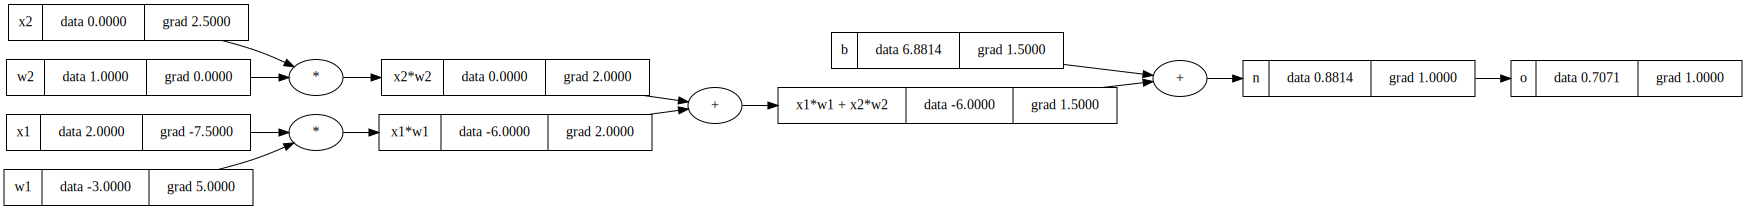

In [311]:
# after adding _backward() attribute in the Value class: 

o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

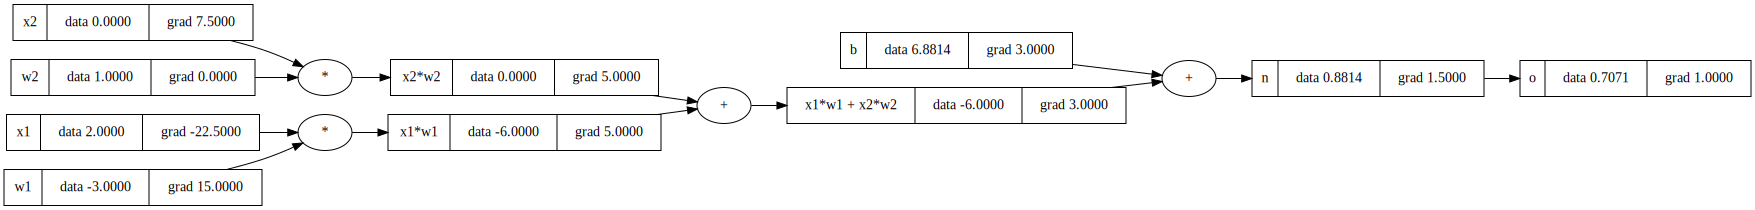

In [312]:
# after adding the backward() method in the Value class:

o.backward()
draw_dot(o)

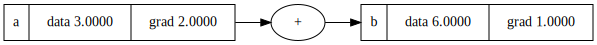

In [313]:
# BUT, there is a bug! Look below: 
a = Value(3.0, label="a")
b = a + a; b.label="b" 
b.backward() 
draw_dot(b)

# the gradient should be 2, not 1, because the nodes are overallping, it doesn't see it. 
# that's why in the Value class, for teh _backward(), we have += instead of  = 
# that's because we are using a variable more than once. So, the grads add up and accumulate and we should let that happen, not reset it.

# Second Half - Manual Backpropagation using 'Value' claas' backward function:

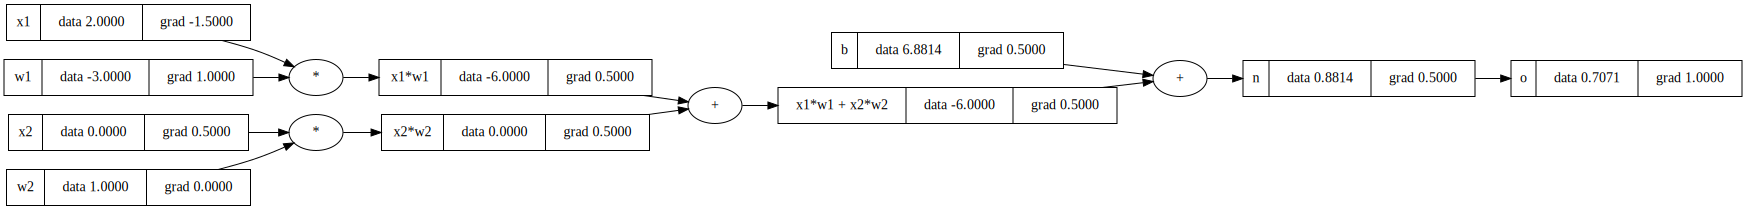

In [314]:
# inputs x1, x2 
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias 
b = Value(6.8813735870195432, label="b") # we change b from teh arbitrary 6.7 to 6.8813735870195432 for a reason later explained!
# x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n" 

# output - activation function 
o = n.tanh(); o.label="o"

o.backward()
draw_dot(o)

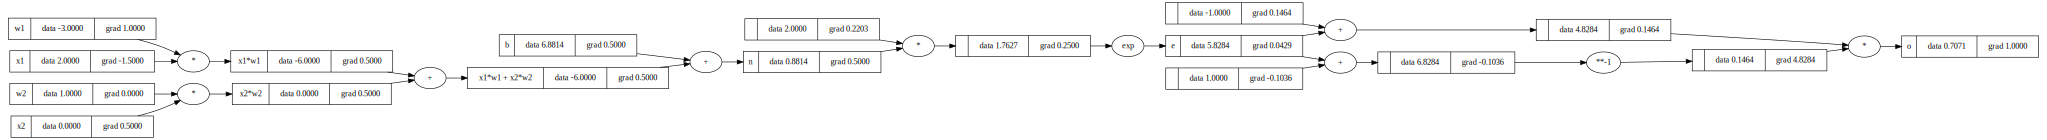

In [315]:
# inputs x1, x2 
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias 
b = Value(6.8813735870195432, label="b") # we change b from teh arbitrary 6.7 to 6.8813735870195432 for a reason later explained!
# x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n" 


# output - activation function 
# o = n.tanh(); o.label="o"
# now, let's open up 'o', and instead of tanh, use: tanh = (e**2n - 1) / (e**2n + 1)
e = (2*n).exp(); e.label = "e"
o = (e-1) / (e+1); o.label = "o"

o.backward()
draw_dot(o)

# Second Half Half - Automatic Backpropagation from Torch: 

In [316]:
import torch 

In [317]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]); w1.requires_grad = True
w2 = torch.Tensor([1.0]); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]); b.requires_grad = True
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.000000238418579


In [318]:
# Now, we will build neural nets. And as we know, neural nets are just a specific class of mathematical expressions ;D

class Neuron: 
    def __init__(self, nin): 
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): 
        # w*x + b 
        act = sum(wi*xi for wi, xi in list(zip(self.w, x))) + self.b 
        # or: act = sum((wi*xi for wi, xi in list(zip(self.w, x))), 0.0) + self.b
        # or: act = sum((wi*xi for wi, xi in list(zip(self.w, x))), self.b) 
        out = act.tanh()
        return out   

    def parameters(self):
        return self.w + [self.b] # all parameters in a single list 


class Layer: 
    def __init__(self, nin, nout): 
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x): 
        out = [n(x) for n in self.neurons] 
        # return out
        return out[0] if len(out)==1 else out ## meaning don't show the list brackets [] at the end if output is only one layer.

    def parameters(self): 
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # or the long version:
        # params = []
        # for neuron in self.neurons: 
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params 


class MLP: 
    def __init__(self, nin, nouts): # here however, nouts is a list of layers sizes. 
        sz = [nin] + nouts 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        return x

    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]

In [319]:
x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
m(x)

Value(data=-0.18779837995293402)

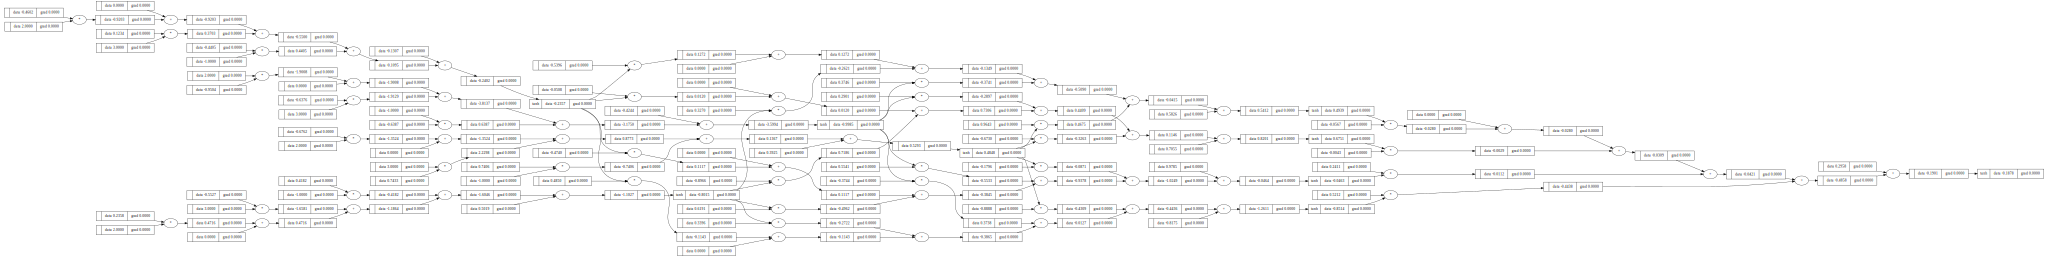

In [320]:
draw_dot(m(x))

In [321]:
# Now, let's checkout a backpropagation scheme with a new dataset xs: 

xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0],
] 

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [m(x) for x in xs] 
ypred 

[Value(data=-0.18779837995293402),
 Value(data=0.5739096472172445),
 Value(data=-0.05047422549521155),
 Value(data=0.21854696894724335)]

In [322]:
# to make the above predictions closer to the desired targets ys, we sould tweak them: 
# first one should increase from -0.88 to be closer to 1
# second one should further decrease 
# third one should decrease a bit 
# and fourth one should increase a bunch. 

# to do so, we need to define and calculate 'loss'. 

# loss = torch.functional.F.binary_cross_entropy()
# mean-squared-error: 
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt = y ground truth 
print(loss)

# Now, we want to minimize the loss.

Value(data=5.400324605212784)


In [323]:
loss.backward()

In [324]:
m.layers[0].neurons[0].w

[Value(data=-0.4601527737929234),
 Value(data=0.12343036443054678),
 Value(data=-0.44049209684566537)]

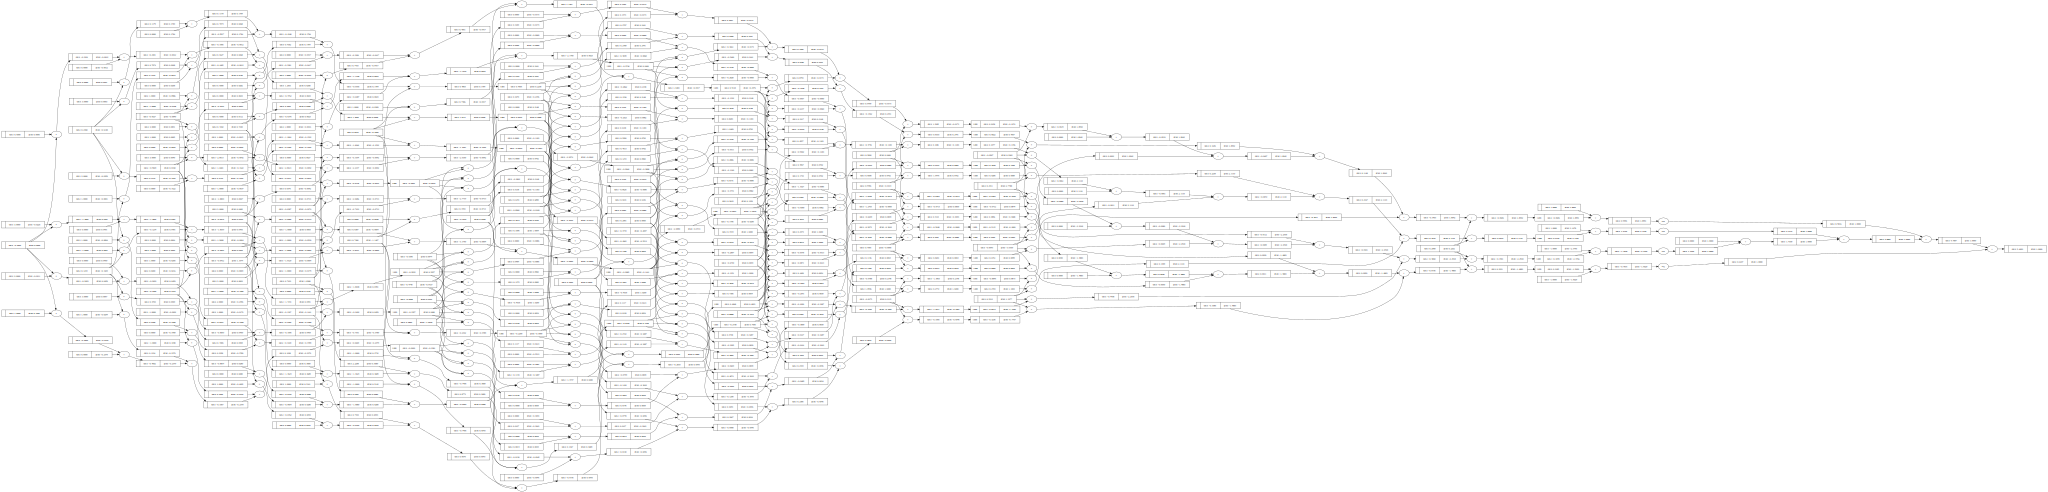

In [325]:
draw_dot(loss)

In [326]:
# Now, let's add the 'parameters()' function to all three classes Neuron, Layer, and MLP. 

x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
print(m(x))
print(m.parameters())
print(len(m.parameters()))

Value(data=-0.22180818942057168)
[Value(data=0.6126810572043482), Value(data=0.5634437986621172), Value(data=-0.44663722705117337), Value(data=0.6773903669989514), Value(data=-0.9620927987164118), Value(data=-0.0590753594477571), Value(data=-0.1640467079397605), Value(data=-0.28718040302646175), Value(data=0.7730615678370418), Value(data=0.7494446295223138), Value(data=0.24081634960344744), Value(data=-0.2877005846584224), Value(data=-0.9433464235056066), Value(data=0.8216026303240029), Value(data=-0.43219044281071506), Value(data=0.6457302523934523), Value(data=0.5123967381624619), Value(data=-0.5153207758297502), Value(data=-0.028833118775874134), Value(data=-0.12222050755787794), Value(data=0.8566750702095707), Value(data=-0.764200460032213), Value(data=-0.06343573464022101), Value(data=-0.2264369171310454), Value(data=-0.09193880083942174), Value(data=-0.6931373754476822), Value(data=0.8975743540448271), Value(data=-0.012294519030847884), Value(data=0.252841953974448), Value(data=0

In [327]:
# Now, repeating from before: 

xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0],
] 

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [m(x) for x in xs] 
print('ypred: \n', ypred, '\n') 
# so, ypred[0] should increase to get closer to ys[0]

# Loss:
# [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt = y ground truth 
print('loss: \n', loss, '\n')

loss.backward()
print('example weight (w[0]): \n', m.layers[0].neurons[0].w[0].data, '\n')
print('grad of w[0]: \n', m.layers[0].neurons[0].w[0].grad)
# the value above, confirms that the gradient of w[0] is +, so as to increase ypred[0].

ypred: 
 [Value(data=-0.22180818942057168), Value(data=-0.2796079296128108), Value(data=-0.2576037522714072), Value(data=-0.20317506032923535)] 

loss: 
 Value(data=4.010562401251669) 

example weight (w[0]): 
 0.6126810572043482 

grad of w[0]: 
 0.026166235532094222


In [328]:
# Now, we want to apply optimization:abs
# aka, applying the calculated grad of the parameters to the parameters so as to update them in order to reduce the future loss:
loss.backward() 

for p in m.parameters(): 
    # updating/tweaking the parameters: 
    p.data += -0.01 * p.grad # 0.01 is the step size # - because the value of w[0] was -


# so if we calculate loss again, it should have decreased! 

ypred = [m(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # ygt = y ground truth 
print('loss: \n', loss)

# Now, let's run this very cell several times, and each time we should see that the loss is decreasing.

loss: 
 Value(data=4.815206972198161)


In [329]:
# Now, if we look at 'ypred', the values should be getting closer to ys

ypred

[Value(data=0.6546733363990904),
 Value(data=0.4407679329428817),
 Value(data=0.5823373364218171),
 Value(data=0.6588947599736558)]

In [330]:
print('example weight (w[0]): \n', m.layers[0].neurons[0].w[0].data, '\n')

example weight (w[0]): 
 0.6056238814898228 



In [331]:
# That was basically a traiing process. Now, let's clean teh previous cells below and make it more respectable: 

xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0],
] 
ys = [1.0, -1.0, -1.0, 1.0] 

for epoch in range(20):
    # The forward pass:
    ypred = [m(x) for x in xs] # 1. make a prediction 
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # 2. calculate the loss

    # Flush the old grads: (is important from the 2nd epoch onwards)
    for p in m.parameters(): 
        p.grad = 0.0
    
    # The backward pass:
    loss.backward() # 3. calculate the grads 

    # Update:
    for p in m.parameters(): # 4. optimize and update the parameters  
        # updating/tweaking the parameters: 
        p.data += -0.05 * p.grad 


    print(f"epoch {epoch}, loss {loss.data}")

print(ypred) # should be close to ys

epoch 0, loss 4.815206972198161
epoch 1, loss 3.0238592064705996
epoch 2, loss 2.663930105037068
epoch 3, loss 2.267506644913282
epoch 4, loss 1.8815618644760168
epoch 5, loss 1.4950007571051356
epoch 6, loss 1.144853446896723
epoch 7, loss 0.8041981801049858
epoch 8, loss 0.47282028568101886
epoch 9, loss 0.2967604418239351
epoch 10, loss 0.2258609210004318
epoch 11, loss 0.18169012930750447
epoch 12, loss 0.15028249164538104
epoch 13, loss 0.12712165744402792
epoch 14, loss 0.10950676185283686
epoch 15, loss 0.09575601061689483
epoch 16, loss 0.08478226673905626
epoch 17, loss 0.07585857552732705
epoch 18, loss 0.06848397206858162
epoch 19, loss 0.06230392098806666
[Value(data=0.860664997012207), Value(data=-0.8974521078938017), Value(data=-0.8773502310939243), Value(data=0.868354103967043)]
